<a href="https://colab.research.google.com/github/seyonechithrananda/ScaleRez/blob/master/GAN_Percept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation, Dense, Input, Dropout
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os, cv2
import tensorflow as tf
from keras import losses
from keras.optimizers import SGD,RMSprop,adam
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization, ZeroPadding2D
from keras.models import load_model
from IPython.display import clear_output
from sklearn.utils import shuffle
from keras.utils import np_utils
from keras.models import Sequential

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from zipfile import ZipFile
file_name = "/content/drive/My Drive/Deeplearning/Meta.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
PATH = os.getcwd()
# Define data path
data_path = "/content/drive/My Drive/Meta"
data_dir_list = os.listdir(data_path)

img_rows=50
img_cols=50
num_channel=3

img_data_list=[]
img_target_list=[]
count=0
print("Working....")
for img in data_dir_list:
    path =  os.path.join(data_path, img)
    input_img = cv2.imread(path)
    input_img=cv2.resize(input_img,(100,100))
    img_data_list.append(input_img)
    count+=1
    if(count%1000==0):
        print(count)
    if(count == 12):
        imgplt=plt.imshow(input_img)
        plt.show()
print("Done loading Training")
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
print("Done Transforming")
print (img_data.shape[0])
print (img_data[0].shape)
print("Completed!")
x_train = img_data[0:100,:,:,:]
x_test = img_data[101:104,:,:,:]
count=0
print (x_test.shape)
print(x_train.shape)
count=0

for img in data_dir_list:
    path =  os.path.join(data_path, img)
    input_img = cv2.imread(path)
    target_img=cv2.resize(input_img,(400,400))
    img_target_list.append(target_img)
    count+=1
    if(count%1000==0):
        print(count)
    if(count == 12):
        imgplt=plt.imshow(target_img)
        plt.show()
print("Done loading target")
target_data = np.array(img_target_list)
target_data = target_data.astype('float32')
target_data /= 255
print("Done Transforming")
print (target_data.shape[0])
print (target_data[0].shape)
print("Completed!")
target_data_train = target_data[0:100,:,:,:]
target_data_test = target_data[101:104,:,:,:]

Working....
Done loading Training
Done Transforming
2
(100, 100, 3)
Completed!
(0, 100, 100, 3)
(2, 100, 100, 3)
Done loading target
Done Transforming
2
(400, 400, 3)
Completed!


In [0]:
# Network parameters
input_shape = (100, 100, 3)
batch_size = 1
kernel_size = 3
latent_dim = 8
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [16, 32]

In [0]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               padding='same', kernel_initializer='glorot_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 50, 50, 16)        448       
_________________________________________________________________
batch_normalization_52 (Batc (None, 50, 50, 16)        64        
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
batch_normalization_53 (Batc (None, 25, 25, 32)        128       
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 25, 25, 32)        0   

In [0]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,kernel_size=kernel_size, strides=2, padding='same' ,kernel_initializer='glorot_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
x = Conv2DTranspose(filters=3, kernel_size=kernel_size, strides=2, padding='same', kernel_initializer='glorot_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2DTranspose(filters=3, kernel_size=kernel_size, strides=2, padding='same', kernel_initializer='glorot_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2DTranspose(filters=3, kernel_size=kernel_size, padding='same', kernel_initializer='glorot_normal')(x)
x = BatchNormalization()(x)
outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 20000)             180000    
_________________________________________________________________
reshape_6 (Reshape)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_54 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 100, 100, 16)      4624

In [0]:
disc_inputs = Input(shape=(400,400,3), name='disc_input')
x = disc_inputs
x = Conv2D(filters=3, kernel_size=kernel_size,strides=1, padding='same', kernel_initializer='glorot_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(filters=32, kernel_size=kernel_size,strides=2, padding='same', kernel_initializer='glorot_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(filters=64, kernel_size=kernel_size,strides=2, padding='same', kernel_initializer='glorot_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(filters=128, kernel_size=kernel_size,strides=2, padding='same', kernel_initializer='glorot_normal')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Flatten()(x)
x = Dense(16)(x)
out = Dense(2, name='out')(x)
disc = Model(disc_inputs, out, name='discrim')
disc.summary()

Model: "discrim"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
disc_input (InputLayer)      (None, 400, 400, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 400, 400, 3)       84        
_________________________________________________________________
batch_normalization_59 (Batc (None, 400, 400, 3)       12        
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 400, 400, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization_60 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 200, 200, 32)      0   

In [0]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        plt.savefig('SRCNN', dpi = None)
        
plot_losses = PlotLosses()

In [0]:
from keras.optimizers import SGD,RMSprop,Adam
sgd = SGD(lr=1e-2, clipnorm=1, clipvalue=0.5)


disc.compile(loss='binary_crossentropy', optimizer=sgd,  metrics=['acc'])
gen = Model(inputs, decoder(encoder(inputs)), name='Generator')
z = Input(shape=((100,100,3,)))
img = gen(z)
disc.summary()
disc.trainable = False
valid = disc(img)
gan = Model(z, valid, name='GAN')

gan.compile(loss='binary_crossentropy',  optimizer=sgd,  metrics=['acc'])

gan.summary()


Model: "discrim"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
disc_input (InputLayer)      (None, 400, 400, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 400, 400, 3)       84        
_________________________________________________________________
batch_normalization_59 (Batc (None, 400, 400, 3)       12        
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 400, 400, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization_60 (Batc (None, 200, 200, 32)      128       
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 200, 200, 32)      0   

In [0]:
gen.compile(loss='mean_squared_logarithmic_error', optimizer=sgd,  metrics=['acc'])
gen.fit(x_train,target_data_train, validation_data=(x_test, target_data_test), callbacks=[plot_losses], verbose=0, epochs=1000, batch_size=1)

KeyboardInterrupt: ignored

In [0]:
train = []
epoch=30
num_sample=15
num_classes = 2

for epoch in range (epoch):
  #gen.fit(x_train,target_data_train, validation_data=(x_test, target_data_test), callbacks=[plot_losses], verbose=0, epochs=100, batch_size=1)
  real_labels = np.ones((15,2))
  fake_labels = np.zeros((15,2))
    #----------------
    #Train on just the discrim
    #----------------
    #train on real
  print("Train on real")
  d_loss_real = disc.train_on_batch(target_data_train,real_labels)
    #train on fake
  fake = gen.predict(x_train)
  d_loss_fake = disc.train_on_batch(fake, fake_labels)
    #average of the loss
  print("Train on fake")
  d_loss = 0.5 *np.add(d_loss_real, d_loss_fake)
    #----------------
    #Train on entire model
    #----------------
  print('GAN TRAIN')
  g_loss = gan.train_on_batch(x_train, fake_labels) 
  print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))
    # If at save interval => save generated image samples


Train on real


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on fake
GAN TRAIN
0 [D loss: 8.575016, acc.: 25.00%] [G loss: 2.803473]
Train on real
Train on fake
GAN TRAIN


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 6.804643, acc.: 0.00%] [G loss: 0.000000]
Train on real
Train on fake
GAN TRAIN
2 [D loss: 6.519782, acc.: 3.33%] [G loss: 0.000000]
Train on real
Train on fake
GAN TRAIN
3 [D loss: 5.909968, acc.: 1.67%] [G loss: 0.000000]
Train on real
Train on fake
GAN TRAIN
4 [D loss: 5.909968, acc.: 1.67%] [G loss: 0.000000]
Train on real
Train on fake
GAN TRAIN
5 [D loss: 5.909968, acc.: 1.67%] [G loss: 0.000000]
Train on real
Train on fake
GAN TRAIN
6 [D loss: 5.909968, acc.: 1.67%] [G loss: 0.000000]
Train on real
Train on fake
GAN TRAIN
7 [D loss: 5.909968, acc.: 1.67%] [G loss: 0.000000]
Train on real
Train on fake
GAN TRAIN
8 [D loss: 5.909968, acc.: 1.67%] [G loss: 0.000000]
Train on real
Train on fake
GAN TRAIN
9 [D loss: 5.909968, acc.: 1.67%] [G loss: 0.000000]
Train on real
Train on fake
GAN TRAIN
10 [D loss: 5.909968, acc.: 1.67%] [G loss: 0.000000]
Train on real
Train on fake
GAN TRAIN
11 [D loss: 5.909968, acc.: 1.67%] [G loss: 0.000000]
Train on real
Train on fake
GAN TRA

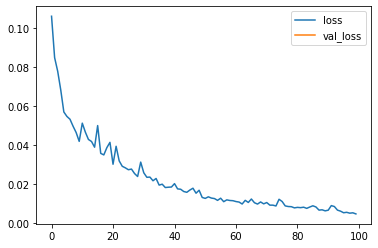

<Figure size 432x288 with 0 Axes>

In [0]:
sgd = SGD(lr=100, clipnorm=1, clipvalue=0.5)
gen.compile(loss='mean_squared_logarithmic_error', optimizer=sgd,  metrics=['acc'])
gen.fit(x_train,target_data_train, validation_data=(x_test, target_data_test), callbacks=[plot_losses], verbose=0, epochs=100, batch_size=1)

In [0]:
fname = 'SRGAN.h5'
gen.save(fname,overwrite=True)
from keras.models import load_model

In [0]:
fname = 'SRGAN.h5'
gen=load_model(fname)

In [0]:
model_json = gen.to_json()
with open("gen.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
gen.save_weights("gen.h5")
print("Saved model to disk")

Saved model to disk


(15, 400, 400, 3)


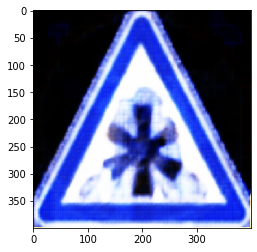

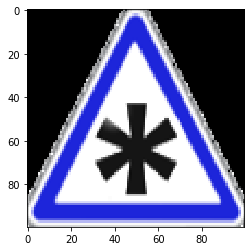

In [0]:
x_decoded = gen.predict(x_train)
from PIL import Image
print(x_decoded.shape)
test = x_decoded[6, : , :, :]
test =(test*255).astype(np.uint8)
plt.imshow(test,  interpolation='none', cmap='gray')
plt.show()
Image.fromarray(test).save('decode2.png')
test1 = x_train[6, :, :, :]
test1 =(test1*255).astype(np.uint8)
plt.imshow(test1,  interpolation='none', cmap='gray')
plt.show()
Image.fromarray(test1).save('encode2.png')